# Final assignment Unsupervised Learning

## The dataset

The dataset can be download here:

clinical data
https://wiki.cancerimagingarchive.net/download/attachments/16056856/Lung3.metadata.xls?version=1&modificationDate=1404237338168&api=v2

Gene Expression data
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE58nnn/GSE58661/matrix/

## Background
This dataset is from NSCLC-Radiomics-Genomics https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics-Genomics with 89  non-small cell lung cancer (NSCLC) patients that were treated with surgery. The dataset included gene expression data, and clinical data. In this assignment, I will combine the dataset and use unsupervised learning to develop an model for predicting lung cancer.

## Load and inspect the data

1. Load the data
2. Inspect the data.
    - Are there missing values?
    - Check the outlier and skewed or not.
    - Can all genes be used or do we have to throw some away?
    - How are the genes distributed
3. Make the data set ready for clustering.

In [46]:
# Load module
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics import adjusted_rand_score

## Load in gene expression data

In [47]:
# Load the data
gdf = pd.read_csv("data/GSE58661_series_matrix.txt.gz",compression="gzip", header=61, sep='\t', quotechar='"')
# check the head and the tail of the df
gdf.head()

,ID_REF,GSM1416528,GSM1416529,GSM1416530,GSM1416531,GSM1416532,GSM1416533,GSM1416534,GSM1416535,GSM1416536,...,GSM1416607,GSM1416608,GSM1416609,GSM1416610,GSM1416611,GSM1416612,GSM1416613,GSM1416614,GSM1416615,GSM1416616
0,AFFX-BioB-3_at,7.376915,8.024915,7.522543,7.152864,7.211031,7.704962,7.779374,7.136893,7.160221,...,7.611992,7.345206,7.316975,7.418340,7.756286,7.215856,7.465109,7.245458,7.039592,7.393667
1,AFFX-BioB-5_at,6.984530,7.427048,7.077207,6.849513,6.753131,7.195947,7.429800,6.745630,6.751358,...,7.175015,7.014479,6.913879,6.898449,7.347570,6.740992,7.080787,6.725812,6.575376,7.041106
2,AFFX-BioB-M_at,7.330576,8.010530,7.334551,7.143286,7.077163,7.753484,7.712429,7.036303,7.089186,...,7.612393,7.285821,7.324635,7.408880,7.745624,7.152722,7.422373,7.263596,6.975162,7.366620
3,AFFX-BioC-3_at,10.922741,11.390638,10.936703,10.791909,10.701328,11.221732,11.084229,10.588372,10.628909,...,11.097486,10.908682,10.781228,10.935723,11.200635,10.707980,10.736531,10.770440,10.367009,10.753221
4,AFFX-BioC-5_at,11.032030,11.533338,11.018510,10.875259,10.823792,11.276973,11.178643,10.700420,10.779332,...,11.265739,10.990373,10.900765,11.101546,11.343329,10.842697,10.900509,10.838008,10.494806,10.863600


In [48]:
gdf.tail()

,ID_REF,GSM1416528,GSM1416529,GSM1416530,GSM1416531,GSM1416532,GSM1416533,GSM1416534,GSM1416535,GSM1416536,...,GSM1416607,GSM1416608,GSM1416609,GSM1416610,GSM1416611,GSM1416612,GSM1416613,GSM1416614,GSM1416615,GSM1416616
60603,merck2-Z70222_a_at,6.892053,5.513603,6.112918,6.276813,7.041829,7.560786,7.446324,7.821045,7.465401,...,7.028523,6.229570,7.543618,7.518894,6.541189,6.493021,7.952822,6.978308,7.460604,7.519374
60604,merck2-Z70608_x_at,1.777216,1.940099,1.753519,1.889742,1.686633,1.988420,1.723665,2.029634,1.986343,...,3.246869,1.910438,1.910438,2.054199,1.730252,1.924313,1.783032,1.371800,1.811532,2.444065
60605,merck2-Z72499_a_at,9.031084,9.527973,9.515653,9.383670,9.464486,9.558521,9.651009,9.479608,9.417764,...,9.349558,9.377011,9.379870,9.398441,9.269749,9.223950,9.481911,9.632680,9.313734,9.527973
60606,merck2-Z75331_a_at,7.284069,6.985508,6.556233,7.293852,6.244336,5.562862,6.933691,6.389961,6.860160,...,6.622611,6.406113,6.642260,6.292372,6.618915,5.817185,7.487134,7.410402,6.396247,5.605377
60607,!series_matrix_table_end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare the gene expression data

In [49]:
# set the index to the ID and remove the less column (all nan)
gdf = gdf.set_index("ID_REF").transpose().drop(columns="!series_matrix_table_end")
print(f"In this dataset, there is {gdf.isnull().sum().sum()} NaN.")

In this dataset, there is 0 NaN.


In [50]:
# There are too many genes we must use some method to reduce the dimension of the dataset.
# Let's do it after concatenate the data.
gdf.shape

(89, 60607)

In [51]:
# check the outlier 
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
clf = LocalOutlierFactor(contamination = 0.01)
prediction = clf.fit_predict(gdf.values)
print("There are {} of outliers detected".format(abs(prediction[prediction < 0].sum())))
print("There are {} of normal distributed sample".format(prediction[prediction > 0].sum()))
outliers = gdf.index[np.where(prediction<0)[0]].values
print("{} are outliers.".format(outliers))
# There is only one outliers. We must standardize the data before clustering.


There are 1 of outliers detected
There are 88 of normal distributed sample
['GSM1416538'] are outliers.


In [52]:
# .skew 0: no skew, + right skew, - left skew, look for above .75
# check the skew data and also handle it.
# https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725
skew_columns = (gdf
                .skew()
                .sort_values(ascending=False))
skew_columns = skew_columns.loc[skew_columns > 0.75]
print(skew_columns)
print("There are {} skew columns.".format(len(skew_columns)))

ID_REF
merck-NC_001526_ORF_1178_at    9.014309
merck-NC_001526_ORF_1180_at    8.944469
merck-NC_001526_ORF_1182_at    8.699111
merck-BX648957_at              8.601416
merck-NC_001526_ORF_1179_at    8.505894
                                 ...   
merck-NM_152539_at             0.750148
merck-ENST00000378906_at       0.750100
merck-AK127029_at              0.750061
merck2-AL713762_at             0.750046
merck2-BE222032_at             0.750005
Length: 16116, dtype: float64
There are 16116 skew columns.


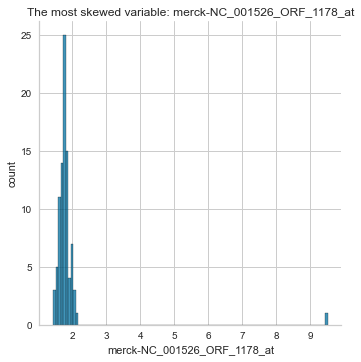

In [53]:
# Before transformation
sns.displot(gdf['merck-NC_001526_ORF_1178_at'])
plt.xlabel('merck-NC_001526_ORF_1178_at'); plt.ylabel('count')
plt.title("The most skewed variable: merck-NC_001526_ORF_1178_at")
plt.show()

In [54]:
# transform skewed distribution to a normal distribution
for col in skew_columns.index.tolist():
    gdf[col] = np.log1p(gdf[col])

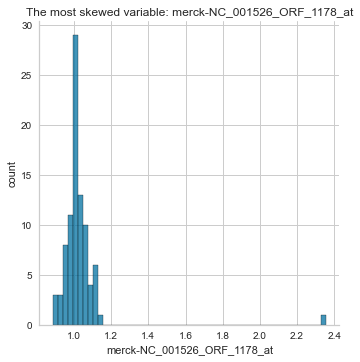

In [55]:
# After transformation
sns.displot(gdf['merck-NC_001526_ORF_1178_at'])
plt.xlabel('merck-NC_001526_ORF_1178_at'); plt.ylabel('count')
plt.title("The most skewed variable: merck-NC_001526_ORF_1178_at")
plt.show()

## Load in clinical data

In [56]:
curl = "https://wiki.cancerimagingarchive.net/download/attachments/16056856/Lung3.metadata.xls?version=1&modificationDate=1404237338168&api=v2"
cr = requests.get(curl)
open('clinical.xls', 'wb').write(cr.content)
cdf = pd.read_excel('clinical.xls')

In [57]:
cdf.head()

,sample.name,title,CEL.file,source.location,organism,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade,molecule tested,label,platform
0,LUNG3-01,lung_1,LUNG3-01.CEL,Left Lower Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
1,LUNG3-02,lung_2,LUNG3-02.CEL,Left Lower Lobe,Homo sapiens,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Primary,Not Available,total RNA,biotin,GPL15048
2,LUNG3-03,lung_3,LUNG3-03.CEL,Left Lower Lobe,Homo sapiens,M,Non-Small Cell,11.0,pT3,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
3,LUNG3-04,lung_4,LUNG3-04.CEL,Left Lower Lobe,Homo sapiens,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Primary,Not Available,total RNA,biotin,GPL15048
4,LUNG3-05,lung_5,LUNG3-05.CEL,Left Lower Lobe,Homo sapiens,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,Primary,2,total RNA,biotin,GPL15048


In [58]:
cdf.tail()

,sample.name,title,CEL.file,source.location,organism,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade,molecule tested,label,platform
84,LUNG3-85,lung_85,LUNG3-85.CEL,Right Upper Lobe,Homo sapiens,M,"Adenocarcinoma, Acinar Type",2.2,pT1b,pN0,pM0,Primary,Not Available,total RNA,biotin,GPL15048
85,LUNG3-86,lung_86,LUNG3-86.CEL,Right Upper Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",5.0,pT3,PN2,pM0,Primary,3,total RNA,biotin,GPL15048
86,LUNG3-87,lung_87,LUNG3-87.CEL,Right Middle Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, Papillary",3.5,pT2,pN0,pM0,Primary,2,total RNA,biotin,GPL15048
87,LUNG3-88,lung_88,LUNG3-88.CEL,Right Upper Lobe,Homo sapiens,M,"Non-Small Cell, Pleomorphic Type",8.5,pT3,pN0,pM0,Primary,Not Available,total RNA,biotin,GPL15048
88,LUNG3-89,lung_89,LUNG3-89.CEL,Left Upper Lobe,Homo sapiens,F,"Squamous Cell Carcinoma, NOS",3.5,pT2,pN1,pM0,Primary,1,total RNA,biotin,GPL15048


In [59]:
# There is one nan in characteristics.tag.tumor.size.maximumdiameter
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 16 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   sample.name                                     89 non-null     object 
 1   title                                           89 non-null     object 
 2   CEL.file                                        89 non-null     object 
 3   source.location                                 89 non-null     object 
 4   organism                                        89 non-null     object 
 5   characteristics.tag.gender                      89 non-null     object 
 6   characteristics.tag.histology                   89 non-null     object 
 7   characteristics.tag.tumor.size.maximumdiameter  88 non-null     float64
 8   characteristics.tag.stage.primary.tumor         89 non-null     object 
 9   characteristics.tag.stage.nodes              

In [60]:
cdf.shape

(89, 16)

Clearly, most of the clinical data is catergorical data. For 0,1,2 columns are only used for identification. Column 4,11,13,14,15 only contain the single value. For this reasons, these columns will be dropped out.

In [61]:
cdf = cdf.drop(['sample.name',
                'CEL.file','organism',
                'characteristics.tag.primaryVSmets',
                'molecule tested','label',
                'platform'],axis=1)

In [62]:
# https://www.cancer.net/navigating-cancer-care/diagnosing-cancer/stages-cancer
# TX means that there is no information about the tumor or it cannot be measured.
# It cannot be measured, so we fill in with 0.
cdf[cdf["characteristics.tag.tumor.size.maximumdiameter"].isna()]

,title,source.location,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.grade
3,lung_4,Left Lower Lobe,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Not Available


In [63]:
cdf = cdf.fillna(0)

In [64]:
# https://www.cancer.gov/about-cancer/diagnosis-staging/prognosis/tumor-grade-fact-sheet
# Not available can be seen as 0. We can also take a look for these patient.
cdf["characteristics.tag.grade"].unique()

array([3, 'Not Available', 2, 1, 4], dtype=object)

In [65]:
cdf["characteristics.tag.grade"] = cdf["characteristics.tag.grade"].replace("Not Available",0).astype("float")


In [66]:
# change gender to 0(male) or 1(female)
cdf["characteristics.tag.gender"] = cdf["characteristics.tag.gender"].map(dict(zip(['M','F'],[0,1])))

## Combine the dataframe

In [67]:
# combine to df together
with open("data/GSE58661_series_matrix.txt","r") as r:
    for line in r:
        if line.startswith("!Series_sample_id"):
            sample_id = line.replace('"',"").split()
        if line.startswith("!Sample_title"):
            sample_title = line.replace('"',"").split()
data = {"ID_REF":sample_id[1:],"title":sample_title[1:]}
add_title_df = pd.DataFrame(data)
adf = gdf.merge(add_title_df,left_on=gdf.index,right_on="ID_REF")
df = cdf.merge(adf,left_on="title",right_on="title")
df = df.drop(["title","ID_REF"],axis=1)

In [68]:
# rename to a proper name
df = df.rename(columns={"source.location":"location", 
                        "characteristics.tag.gender":"gender",
                        "characteristics.tag.tumor.size.maximumdiameter":"tumor_size",
                        "characteristics.tag.stage.primary.tumor":"primary_stage",
                        "characteristics.tag.stage.nodes":"nodes_stage",
                        "characteristics.tag.stage.mets":"mets_stage",
                        "characteristics.tag.grade":"grade",
                        "characteristics.tag.histology":"histology"})

In [69]:
# The location, stage might affect the result. However, we only want to make sure how to predict the histology.
# So we will remove it.
df = df.drop(['location','primary_stage',"nodes_stage","mets_stage"],axis=1)

## Dimensionality reduction - PCA
The gene expression data is high dimension dataset. We must reduce the dimension of the dataset first. 
There are several method we can use. However, we cannot make sure it is linear data or t-SNE. So, I will try both methods(PCA and t-SNE) to find a better way for dimensionality reduction.

In [70]:
df["Gender"] = df.gender
df = df.drop(columns="gender")

In [71]:
X = df.iloc[:,1:]
y = df['histology']
X

,tumor_size,grade,AFFX-BioB-3_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioC-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-BioDn-5_at,AFFX-BkGr-GC03_at,...,merck2-Z43503_at,merck2-Z47244_x_at,merck2-Z47250_x_at,merck2-Z48501_s_at,merck2-Z48633_s_at,merck2-Z70222_a_at,merck2-Z70608_x_at,merck2-Z72499_a_at,merck2-Z75331_a_at,Gender
0,4.0,3.0,2.125480,2.077506,2.119933,2.478448,2.487572,13.411168,12.625445,0.902130,...,1.677215,7.506299,9.774634,11.295187,10.286077,6.892053,1.021449,2.305689,7.284069,0
1,1.3,0.0,2.199989,2.131447,2.198394,2.516941,2.528392,13.546671,12.898906,0.917141,...,1.521341,5.516440,4.601167,11.443442,11.173715,5.513603,1.078443,2.354036,6.985508,0
2,11.0,3.0,2.142715,2.089046,2.120410,2.479618,2.486448,13.360017,12.540647,0.856684,...,1.370516,6.310065,6.315107,11.584115,10.586540,6.112918,1.012880,2.352865,6.556233,0
3,0.0,0.0,2.098369,2.060452,2.097194,2.467414,2.474457,13.364171,12.579293,0.844816,...,1.362195,5.954062,6.738276,11.240300,10.257621,6.276813,1.061167,2.340234,7.293852,0
4,7.8,2.0,2.105479,2.048097,2.089041,2.459702,2.470114,13.340075,12.420624,0.831512,...,1.415632,7.257312,8.118139,10.998377,10.634072,7.041829,0.988289,2.347987,6.244336,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2.2,0.0,2.106066,2.046530,2.098352,2.460271,2.471711,13.332414,12.397369,0.893481,...,1.466385,8.953402,10.221695,11.252406,11.010846,6.493021,1.073060,2.324733,5.817185,0
85,5.0,3.0,2.135953,2.089489,2.130892,2.462706,2.476581,13.285086,12.356609,0.913041,...,1.351061,6.342812,6.896812,11.694623,9.975013,7.952822,1.023541,2.349651,7.487134,0
86,3.5,2.0,2.109662,2.044567,2.111860,2.465591,2.471315,13.469373,12.566290,0.892470,...,1.589908,5.724736,5.820700,11.692384,10.044351,6.978308,0.863649,2.363932,7.410402,0
87,8.5,0.0,2.084378,2.024903,2.076332,2.430715,2.441895,13.214522,12.108750,0.900316,...,1.346528,7.236876,8.625332,10.826930,8.798358,7.460604,1.033730,2.333476,6.396247,0


In [72]:
# before reduce the dimension we should scale it
X = StandardScaler().fit_transform(X)

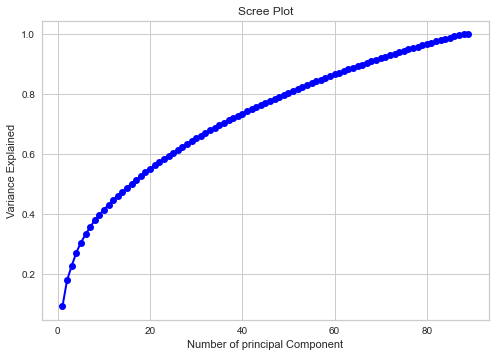

Variance explained by first component 9.34 %
Variance explained by first 2 components 18.06 %


In [73]:
pca_model = PCA(random_state=42,n_components=89)
pca_components = pca_model.fit_transform(X)
principalDf = pd.DataFrame(data = pca_components)

PC_values = np.arange(pca_model.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca_model.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of principal Component')
plt.ylabel('Variance Explained')
plt.show()
pca_cumsum = np.cumsum(pca_model.explained_variance_ratio_)
print('Variance explained by first component {:.2f} %'.format(pca_cumsum[0]*100))
print('Variance explained by first 2 components {:.2f} %'.format(pca_cumsum[1]*100))

/Users/kai/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


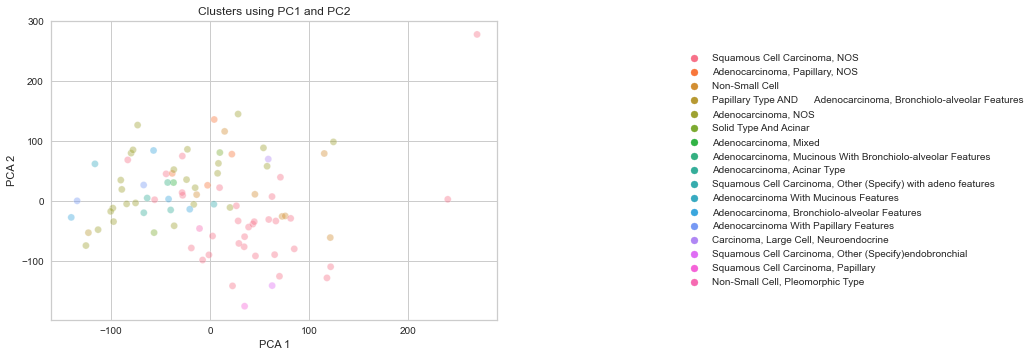

In [74]:
# plt.scatter(principalDf[0], principalDf[1], c=y.values,cmap = "jet", edgecolor = "None", alpha=0.35)
sns.scatterplot(principalDf[0], principalDf[1],hue=y.values,alpha=0.4)
plt.title('Clusters using PC1 and PC2')
plt.xlabel("PCA 1");plt.ylabel("PCA 2")
plt.legend(loc=5, bbox_to_anchor=(2.2, 0.5))
plt.show()
# As the output showed, it did not perform very well. It does not seperate them to different cluster.
# There are too many classes. We should aggregrate them.

In [75]:
df.histology.value_counts()
# We can see the histology is not well distributed. It is better to split it to group with Squamous Cell Carcinoma, Adenocarcinoma,
# and put the rest of the data to other.
# To make every group have similar amount of data.

Squamous Cell Carcinoma, NOS                                            33
Adenocarcinoma, NOS                                                     25
Non-Small Cell                                                           7
Adenocarcinoma, Papillary, NOS                                           4
Adenocarcinoma, Bronchiolo-alveolar Features                             4
Adenocarcinoma, Acinar Type                                              3
Solid Type And Acinar                                                    2
Adenocarcinoma With Papillary Features                                   2
Adenocarcinoma, Mixed                                                    1
Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features               1
Squamous Cell Carcinoma, Other (Specify) with adeno features             1
Adenocarcinoma With Mucinous Features                                    1
Papillary Type AND      Adenocarcinoma, Bronchiolo-alveolar Features     1
Carcinoma, Large Cell, Ne

In [76]:
y = np.where(y.str.contains("Squamous"),"Squamous Cell Carcinoma",
            np.where(y.str.contains("Adenocarcinoma"),"Adenocarcinoma","other"))

/Users/kai/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


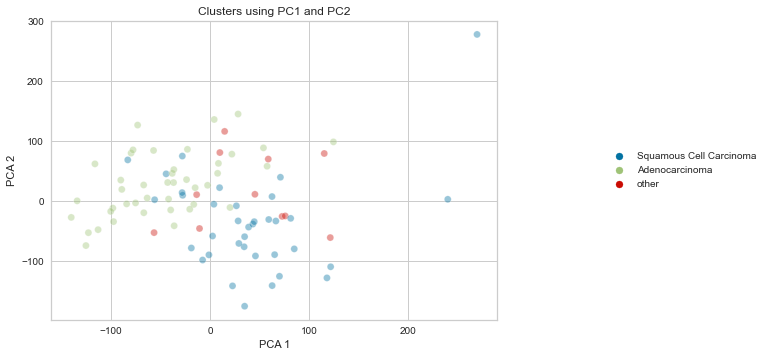

In [94]:
# After aggregrate it, it still does not perform well.
# We have to try non-linear reduction method.
sns.scatterplot(principalDf[0], principalDf[1],hue=y,alpha=0.4)
plt.title('Clusters using PC1 and PC2')
plt.xlabel("PCA 1");plt.ylabel("PCA 2")
plt.legend(loc=5, bbox_to_anchor=(1.6, 0.5))
plt.show()

## Dimensionality reduction - t-SNE

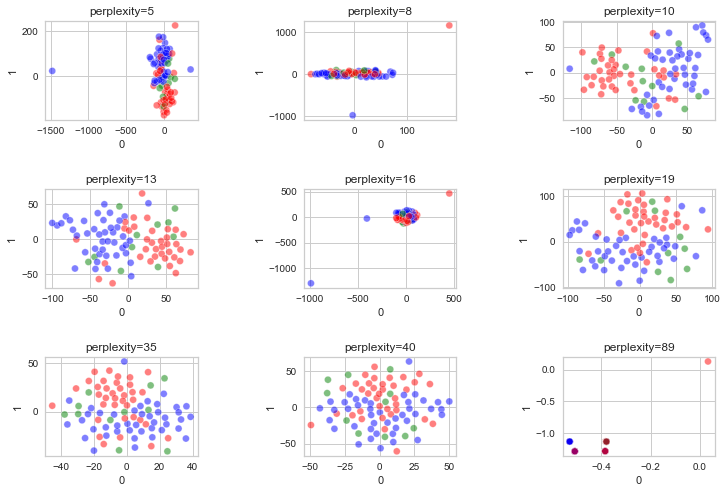

In [78]:
# perplexity = 19 seems better
def plot_sub_cluster(y, df):
    ax = sns.scatterplot(x = df[0], y = df[1], hue = y, 
                         legend = False, alpha = 0.5, palette=['red', 'blue',"green"])
    return ax

p = [5, 8, 10, 13, 16, 19, 35, 40, 89]
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    tsne = TSNE(perplexity=p[i], n_iter= 500).fit_transform(X)
    tsne = pd.DataFrame(tsne)
    plot_sub_cluster(y, tsne)
    ax.set_title(f'perplexity={p[i]}')
plt.show()


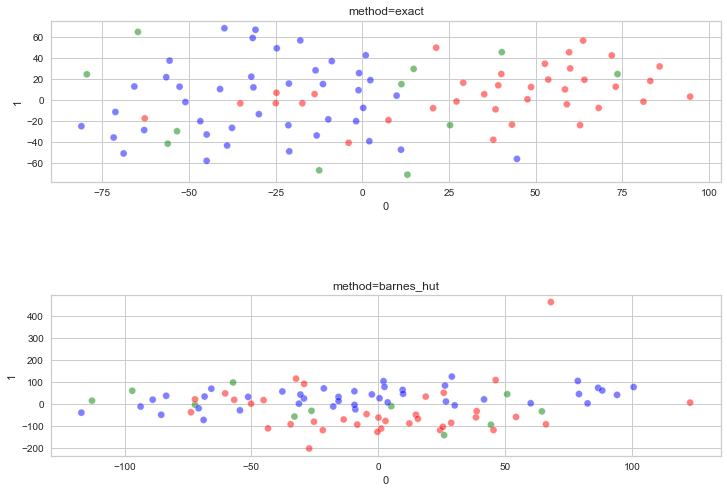

In [79]:
# The defult method (barnes_hut) is better.
p = ["exact","barnes_hut"]
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
for i in range(2):
    ax = fig.add_subplot(2, 1, i+1)
    tsne = TSNE(perplexity=19,method=p[i], n_iter= 500).fit_transform(X)
    tsne = pd.DataFrame(tsne)
    plot_sub_cluster(y, tsne)
    ax.set_title(f'method={p[i]}')
plt.show()

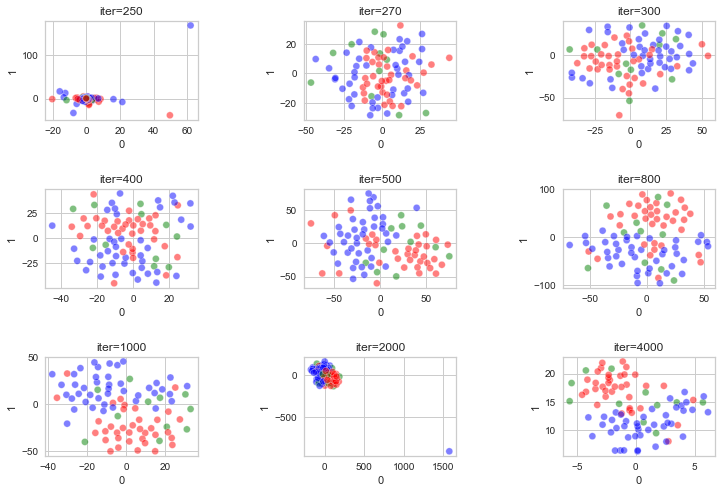

In [80]:
# Iter 2000 is better 
p = [250, 270, 300, 400, 500, 800, 1000, 2000, 4000]
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    tsne = TSNE(perplexity=19, n_iter= p[i]).fit_transform(X)
    tsne = pd.DataFrame(tsne)
    plot_sub_cluster(y, tsne)
    ax.set_title(f'iter={p[i]}')
plt.show()
# Although we try to get a better graph, it does not perform

<AxesSubplot:xlabel='0', ylabel='1'>

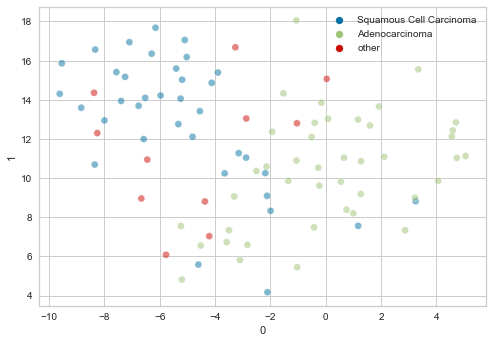

In [81]:
# It perform quite nice to seperate Squamous Cell and Adenocarcinoma, but for the other is not good enough.
tsne = TSNE(perplexity=19, n_iter= 2000).fit_transform(X)
tsne = pd.DataFrame(tsne)
sns.scatterplot(x = tsne[0], y = tsne[1], hue = y, legend = True, alpha = 0.5)


## Dimensionality reduction - PCA on t-SNE

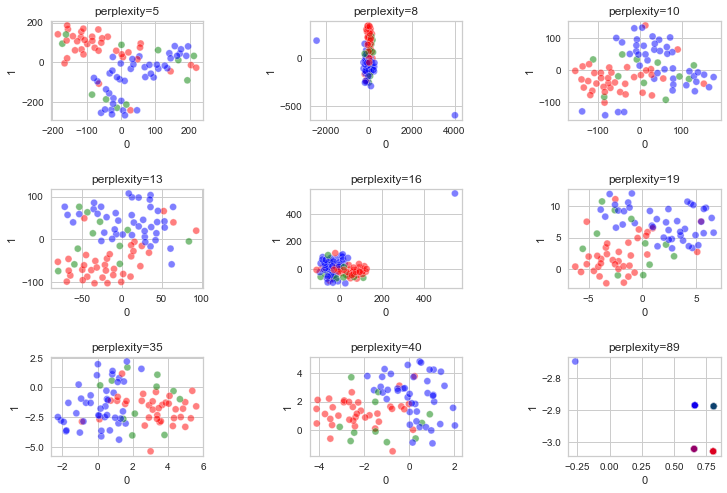

In [82]:
# perplexity = 40 seems better
p = [5, 8, 10, 13, 16, 19, 35, 40, 89]
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    tsne = TSNE(perplexity=p[i]).fit_transform(pca_components)
    tsne = pd.DataFrame(tsne)
    plot_sub_cluster(y, tsne)
    ax.set_title(f'perplexity={p[i]}')
plt.show()

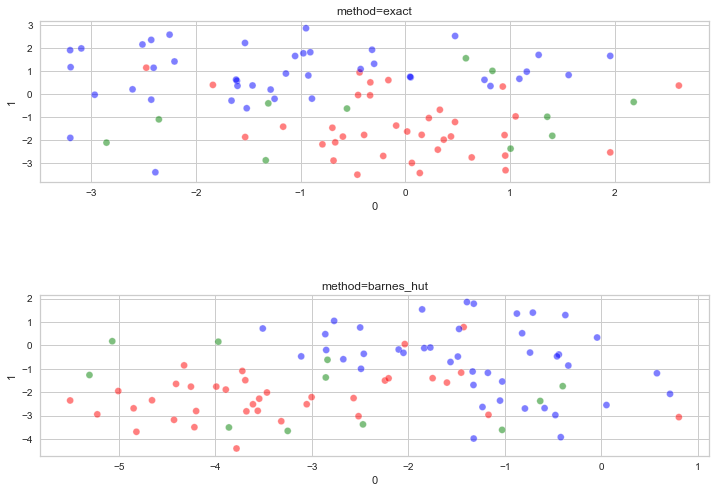

In [83]:
# The defult method (barnes_hut) is better.
p = ["exact","barnes_hut"]
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
for i in range(2):
    ax = fig.add_subplot(2, 1, i+1)
    tsne = TSNE(perplexity=40,method=p[i]).fit_transform(pca_components)
    tsne = pd.DataFrame(tsne)
    plot_sub_cluster(y, tsne)
    ax.set_title(f'method={p[i]}')
plt.show()

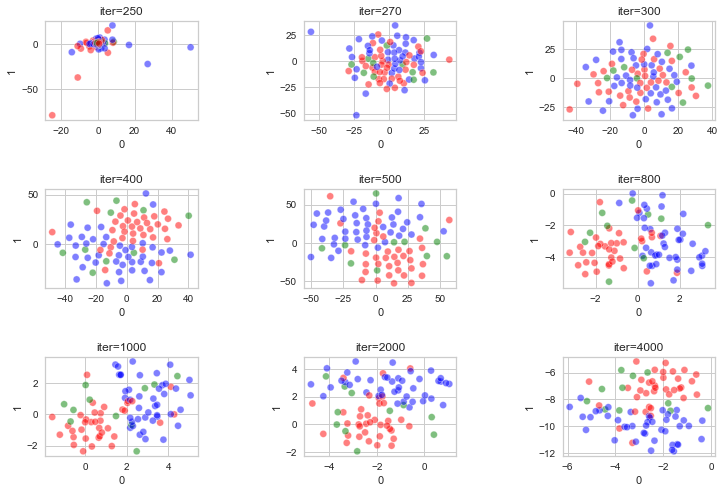

In [84]:
# Iter 2000 is better 
p = [250, 270, 300, 400, 500, 800, 1000, 2000, 4000]
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    tsne = TSNE(perplexity=40, n_iter= p[i]).fit_transform(pca_components)
    tsne = pd.DataFrame(tsne)
    plot_sub_cluster(y, tsne)
    ax.set_title(f'iter={p[i]}')
plt.show()

<AxesSubplot:xlabel='0', ylabel='1'>

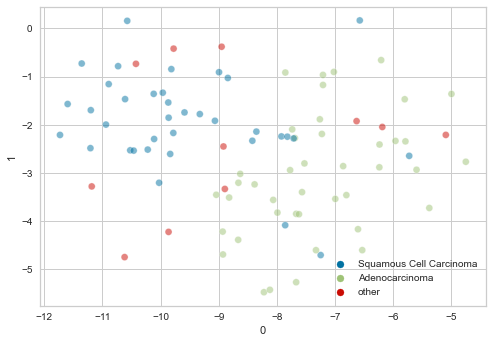

In [85]:
# There is no significant different between PCA on t-SNE and t-SNE.
# So, we will use t-SNE to create a model
tsne = TSNE(perplexity=40, n_iter= 2000).fit_transform(pca_components)
tsne = pd.DataFrame(tsne)
sns.scatterplot(x = tsne[0], y = tsne[1], hue = y, legend = True, alpha = 0.5)

## Create a model

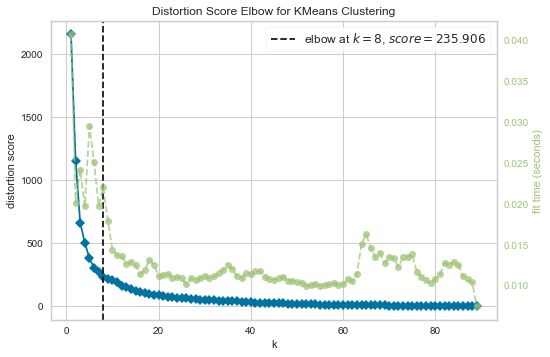

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [86]:
kmeans = KMeans(init='random', n_clusters=3, random_state=42)
tsne = TSNE(perplexity=19, n_iter= 2000).fit_transform(X)
tsne = pd.DataFrame(tsne)
visualizer = KElbowVisualizer(kmeans, k=(1,90)).fit(tsne)
visualizer.show()

0.3213357192372996
0.3474566888362267
0.39172339589514554


(-19.717551398277283,
 -3.5794881105422975,
 -14.056541772931814,
 0.5580227546393872)

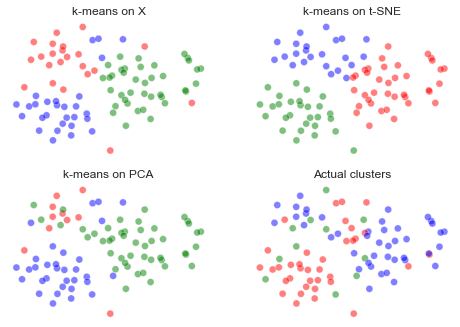

In [92]:
# K-means on original data
n_cluster = 3
kmns = KMeans(n_clusters=n_cluster, init='k-means++')
kY = kmns.fit_predict(X)
plt.subplot(221)
plot_sub_cluster(kY, tsne)
plt.title('k-means on X')
plt.axis('off')
print(adjusted_rand_score(kY, y))

# K-means on original t-SNE results
kmns = KMeans(n_clusters=n_cluster, init='k-means++')
kY = kmns.fit_predict(tsne)
plt.subplot(222)
plot_sub_cluster(kY, tsne)
plt.title('k-means on t-SNE')
plt.axis('off')
print(adjusted_rand_score(kY, y))

# K-means on original PCA results
kmns = KMeans(n_clusters=n_cluster, init='k-means++')
kY = kmns.fit_predict(pca_components)
plt.subplot(223)
plot_sub_cluster(kY, tsne)
plt.title('k-means on PCA')
plt.axis('off')
print(adjusted_rand_score(kY, y))

plt.subplot(224)
plot_sub_cluster(y, tsne)
plt.title('Actual clusters')
plt.axis('off')

## Conclusion
Data is skewed and too many dimension. Reduction the dimension before plotting is very important.
To seperate the clustering better t-SNE seems better. However, the adjusted_rand_score is not good.

## Future
In this model, we only get 0.39 for the score. It still need to improve. In the future, we can try different method for dimension reduction.